In [385]:
# [cross validation: stratified k-fold] 
# Try Spacy for phrases
# [Try adding useful counts as a feature with best model (TF-IDF [1,2] on downsample)]

TF-IDF
In our previous example, many sentences started with the words “it was the time of.”
This contributed a lot to their similarity, but in reality, the actual information you get
by the words is minimal.
TF-IDF will take care of that by counting the number of
total word occurrences. It will reduce weights of frequent words and at the same time
increase the weights of uncommon words.
TfidfVectorizer:
Counts all words in the document and provides weights, penalizing common words and highlighting uncommon ones, tracking similarities between documents 

# Drug dataset - Sentiment Analysis 

In [212]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
#from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/odelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/odelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/odelia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [213]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', encoding="UTF-8")
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', encoding="UTF-8")

## Preliminary data exploration

In [214]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [215]:
# Merge train and test sets

In [216]:
df = pd.concat([df_train, df_test])

In [217]:
df.drugName.value_counts()

Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: drugName, Length: 3671, dtype: int64

In [218]:
df.condition.value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [219]:
df.describe()

,Unnamed: 0,rating,usefulCount,length
count,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,84.682228
std,67007.913366,3.275554,36.346069,44.852532
min,0.000000,1.000000,0.000000,1.000000
25%,58115.500000,5.000000,6.000000,48.000000
50%,115867.000000,8.000000,16.000000,84.000000
75%,173963.500000,10.000000,36.000000,126.000000
max,232291.000000,10.000000,1291.000000,1894.000000


In [220]:
df.drop_duplicates(inplace=True)

In [221]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
 7   length       215063 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.8+ MB


In [223]:
df.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [224]:
sum(df.condition.isnull())

1194

### 'Rating' column

<AxesSubplot:xlabel='rating', ylabel='count'>

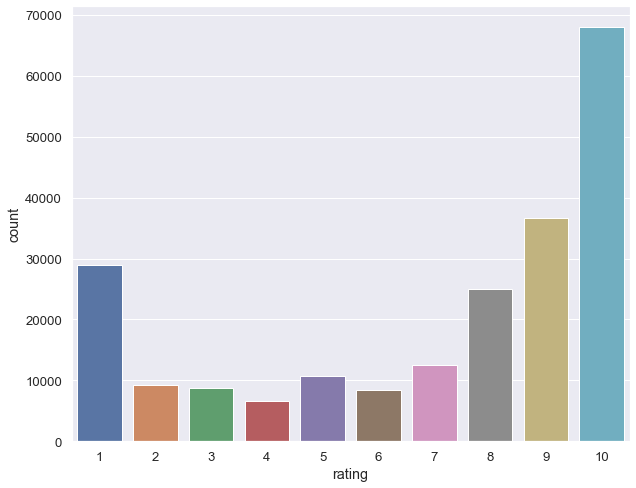

In [225]:
sns.countplot(df['rating'])

In [226]:
# data is skewed, imalanced towards positive ratings

In [227]:
df.rating.value_counts(normalize=True)

10    0.316210
9     0.170685
1     0.134463
8     0.116459
7     0.058341
5     0.049860
2     0.043080
3     0.040537
6     0.039347
4     0.031019
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

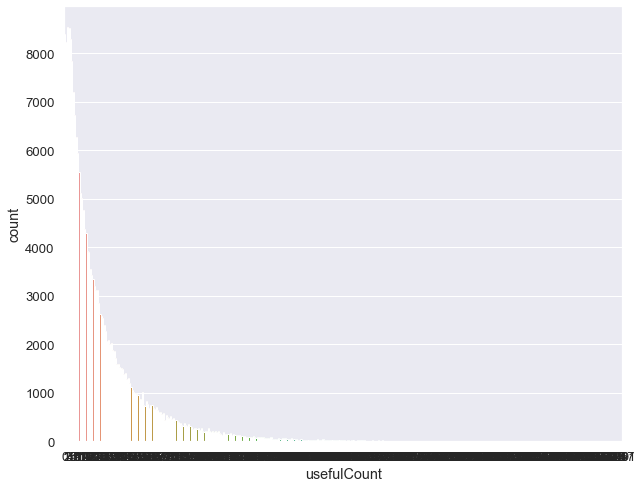

In [228]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

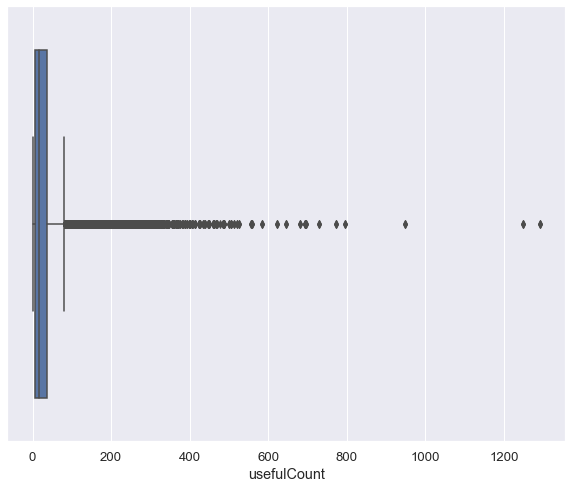

In [229]:
sns.boxplot(x=df['usefulCount'])

In [230]:
df['usefulCount'].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [231]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

8402

In [232]:
df.usefulCount.value_counts()

2      8543
3      8525
0      8402
4      8301
1      8237
       ... 
309       1
337       1
400       1
372       1
288       1
Name: usefulCount, Length: 397, dtype: int64

### General trends in the data

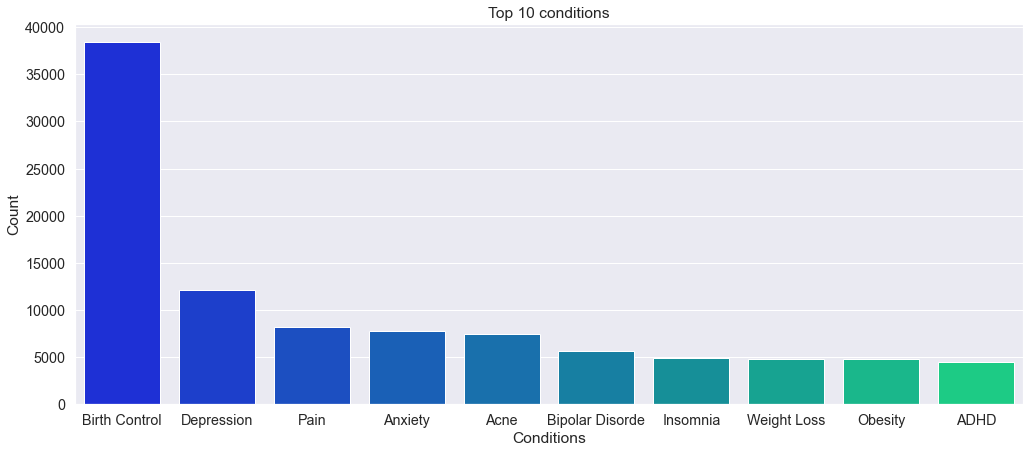

In [233]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

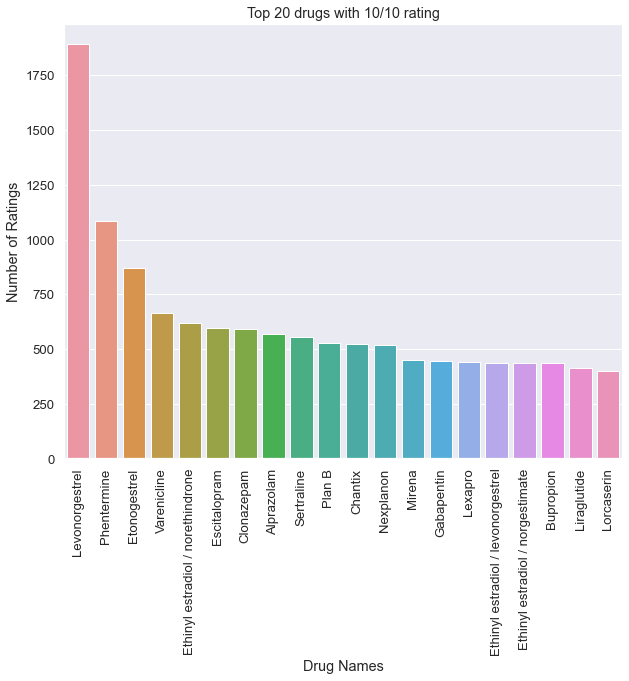

In [234]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

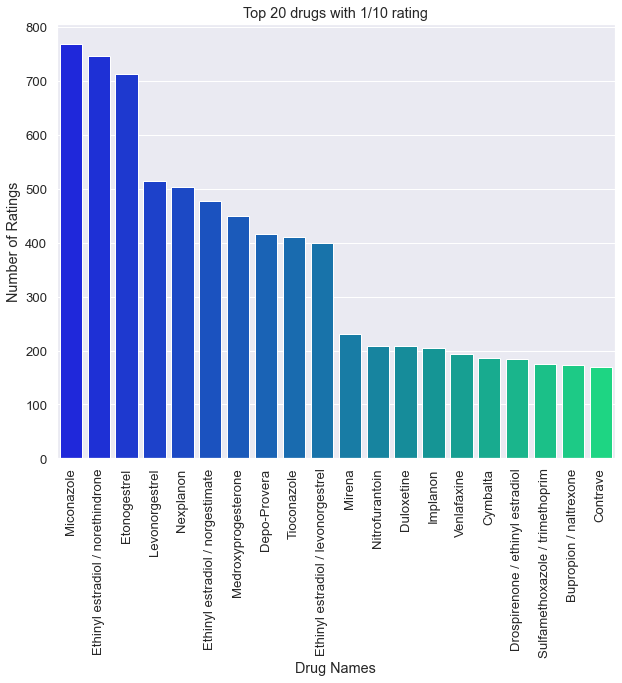

In [235]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

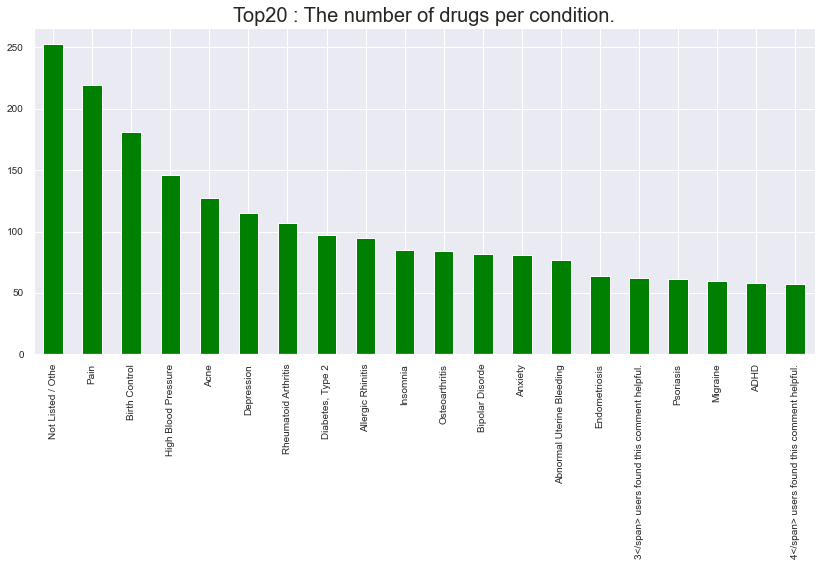

In [236]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

## Data Cleaning

### Clean 'condition' column

In [237]:
df["condition_clean"] = df.condition.apply(lambda x: "unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [238]:
df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

1171

In [239]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [240]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [241]:
df["condition_clean"].nunique()

837

In [242]:
#df = df.dropna()
df
# -1194 records
df.condition.fillna("unknown", axis=0, inplace=True)

### Clean reviews (inplace)

In [243]:
df.drop(["Unnamed: 0","date", "condition"], axis=1, inplace=True)

In [244]:
df["review"] = df.review.str.replace("&#039;", "")
#df

In [245]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [246]:
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...
53761,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",10,43,97,"Breast Cancer, Prevention"
53762,Escitalopram,"""ive been taking lexapro (escitaploprgram) sin...",9,11,130,Anxiety
53763,Levonorgestrel,"""im married, 34 years old and i have no kids. ...",8,7,149,Birth Control
53764,Tapentadol,"""i was prescribed nucynta for severe neck/shou...",1,20,34,Pain


In [248]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,9
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,8
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,5
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,9
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,10
53762,Escitalopram,Anxiety,"""ive been taking lexapro (escitaploprgram) sin...",11,130,9
53763,Levonorgestrel,Birth Control,"""im married, 34 years old and i have no kids. ...",7,149,8
53764,Tapentadol,Pain,"""i was prescribed nucynta for severe neck/shou...",20,34,1


In [552]:
df.to_excel("drugs_cond_cln_plus_reviews.xlsx")

In [249]:
df.loc[df_clean["length"] == max(df["length"]), "length"]
#df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

75663    1894
Name: length, dtype: int64

In [250]:
#df.review.iat[75663]

In [251]:
df_clean_for_reg = df_clean.drop(["review"], axis=1)
df_clean_for_reg

,drugName,condition_clean,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,27,17,9
1,Guanfacine,ADHD,192,141,8
2,Lybrel,Birth Control,17,134,5
3,Ortho Evra,Birth Control,10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,37,124,9
...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention",43,97,10
53762,Escitalopram,Anxiety,11,130,9
53763,Levonorgestrel,Birth Control,7,149,8
53764,Tapentadol,Pain,20,34,1


In [252]:
df_clean_for_reg.to_csv("drugs_df_for_lin_reg.csv")

### Feature engineering: 'rating'

In [253]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",1,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",1,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",0,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",1,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",1,37,124,Opiate Dependence
...,...,...,...,...,...,...
53761,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",1,43,97,"Breast Cancer, Prevention"
53762,Escitalopram,"""ive been taking lexapro (escitaploprgram) sin...",1,11,130,Anxiety
53763,Levonorgestrel,"""im married, 34 years old and i have no kids. ...",1,7,149,Birth Control
53764,Tapentadol,"""i was prescribed nucynta for severe neck/shou...",0,20,34,Pain


In [254]:
df['rating'].value_counts()

1    142306
0     72757
Name: rating, dtype: int64

In [255]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df = df.reindex(columns=column_names)
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1
53762,Escitalopram,Anxiety,"""ive been taking lexapro (escitaploprgram) sin...",11,130,1
53763,Levonorgestrel,Birth Control,"""im married, 34 years old and i have no kids. ...",7,149,1
53764,Tapentadol,Pain,"""i was prescribed nucynta for severe neck/shou...",20,34,0


## Creating the Corpus

In [256]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [257]:
len(corpus)

215063

In [258]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [259]:
len(corpus)

1254242

### Cleaning corpus

In [260]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [261]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [262]:
# Tokenizing the corpus

In [263]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [264]:
len(list(wordfreq.keys()))

49773

In [265]:
wordfreq

{'it': 384381,
 'has': 64543,
 'no': 80330,
 'side': 71323,
 'effect': 14623,
 'i': 998185,
 'take': 58449,
 'in': 168630,
 'combination': 2158,
 'of': 228762,
 'bystolic': 329,
 'mg': 60764,
 'and': 575215,
 'fish': 199,
 'oil': 888,
 'my': 389314,
 'son': 3069,
 'is': 150286,
 'halfway': 247,
 'through': 12769,
 'his': 4209,
 'fourth': 831,
 'week': 38269,
 'intuniv': 259,
 'we': 10003,
 'became': 5849,
 'concerned': 1258,
 'when': 48801,
 'he': 18186,
 'began': 6811,
 'this': 180956,
 'last': 21329,
 'started': 56527,
 'taking': 68293,
 'the': 542846,
 'highest': 472,
 'dose': 20990,
 'will': 35799,
 'be': 53988,
 'on': 182454,
 'for': 269085,
 'two': 28695,
 'days': 54259,
 'could': 19811,
 'hardly': 1808,
 'get': 55121,
 'out': 51296,
 'bed': 8199,
 'was': 235640,
 'very': 52954,
 'cranky': 233,
 'slept': 2383,
 'nearly': 3165,
 'hours': 21618,
 'a': 385295,
 'drive': 9491,
 'home': 4281,
 'from': 51060,
 'school': 4179,
 'vacation': 364,
 'unusual': 568,
 'him': 3967,
 'called': 

### Reducing the corpus

#### Stopwords

In [266]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [267]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [446]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])

In [428]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(71323, 'side'),
 (14623, 'effect'),
 (58449, 'take'),
 (2158, 'combination'),
 (329, 'bystolic'),
 (199, 'fish'),
 (888, 'oil'),
 (3069, 'son'),
 (247, 'halfway'),
 (831, 'fourth'),
 (38269, 'week'),
 (259, 'intuniv'),
 (5849, 'became'),
 (1258, 'concerned'),
 (6811, 'began'),
 (21329, 'last'),
 (56527, 'started'),
 (68293, 'taking'),
 (472, 'highest'),
 (20990, 'dose'),
 (28695, 'two'),
 (54259, 'days'),
 (19811, 'could'),
 (1808, 'hardly'),
 (55121, 'get'),
 (8199, 'bed'),
 (233, 'cranky'),
 (2383, 'slept'),
 (3165, 'nearly'),
 (21618, 'hours'),
 (9491, 'drive'),
 (4281, 'home'),
 (4179, 'school'),
 (364, 'vacation'),
 (568, 'unusual'),
 (3139, 'called'),
 (1036, 'monday'),
 (13897, 'morning'),
 (10614, 'said'),
 (2390, 'stick'),
 (13471, 'see'),
 (19458, 'getting'),
 (9012, 'problem'),
 (6406, 'free'),
 (31214, 'much'),
 (12, 'agreeable'),
 (17131, 'ever'),
 (11072, 'less'),
 (3979, 'emotional'),
 (26541, 'good'),
 (13417, 'thing'),
 (537, 'remembering'),
 (10310, 'things'),
 (615

In [429]:
corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('weight', 36742),
 ('got', 36189),
 ('life', 33897),
 ('since', 33813),
 ('dont', 33790),
 ('bad', 32733),
 ('still', 32562)]

In [430]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 71323),
 ('taking', 68293),
 ('year', 62580),
 ('pain', 60591),
 ('effect', 60335),
 ('first', 59993),
 ('take', 58449),
 ('month', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('day', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('week', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('weight', 36742),
 ('got', 36189),
 ('life', 33897),
 ('since', 33813),
 ('dont', 33790),
 ('bad', 32733),
 ('still', 32562)]

#### LIST 1 [FULL]

In [431]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

Index(['side', 'taking', 'year', 'pain', 'effect', 'first', 'take', 'month',
       'started', 'like', 'get', 'day', 'time', 'feel', 'would', 'back',
       'pill', 'one', 'week', 'took', 'also', 'period', 'weight', 'got',
       'life', 'since', 'dont', 'bad', 'still'],
      dtype='object')

In [432]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [434]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'year': 0,
  'pain': 0,
  'effect': 1,
  'first': 0,
  'take': 1,
  'month': 0,
  'started': 0,
  'like': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 0,
  'took': 0,
  'also': 0,
  'period': 0,
  'weight': 0,
  'got': 0,
  'life': 0,
  'since': 0,
  'dont': 0,
  'bad': 0,
  'still': 0},
 {'side': 0,
  'taking': 1,
  'year': 0,
  'pain': 0,
  'effect': 0,
  'first': 0,
  'take': 0,
  'month': 0,
  'started': 1,
  'like': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 2,
  'took': 0,
  'also': 0,
  'period': 0,
  'weight': 0,
  'got': 0,
  'life': 0,
  'since': 0,
  'dont': 0,
  'bad': 0,
  'still': 0}]

In [435]:
reviews = pd.DataFrame(my_list)

In [436]:
reviews

,side,taking,year,pain,effect,first,take,month,started,like,...,took,also,period,weight,got,life,since,dont,bad,still
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,2,1,1,0,1,0,...,0,0,5,0,1,0,0,0,0,1
3,0,0,0,0,0,3,0,0,0,0,...,0,1,3,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215058,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
215059,0,1,0,0,2,2,1,0,0,4,...,1,0,0,0,0,1,1,0,0,0
215060,0,2,2,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,3
215061,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [437]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

,side,taking,year,pain,effect,first,take,month,started,like,...,also,period,weight,got,life,since,dont,bad,still,rating
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,0,0,2,1,1,0,1,0,...,0,5,0,1,0,0,0,0,1,0
3,0,0,0,0,0,3,0,0,0,0,...,1,3,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215058,1,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
215059,0,1,0,0,2,2,1,0,0,4,...,0,0,0,0,1,1,0,0,0,1
215060,0,2,2,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,3,1
215061,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [438]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
215058    1
215059    1
215060    1
215061    0
215062    1
Name: rating, Length: 215063, dtype: int64

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [440]:
X_train
y_train

,rating
127344,1
98725,1
35998,0
100317,0
148458,1
...,...
45741,1
199403,1
30772,1
147302,0


In [441]:
y_test.value_counts()

rating
1         28461
0         14552
dtype: int64

In [442]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

#nb = CategoricalNB()
rf = RandomForestClassifier()

#nb.fit(X_train, y_train['rating'])
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

### Making predictions with RF

In [443]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [444]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [445]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           0       0.93      0.79      0.86     58205
           1       0.90      0.97      0.94    113845

    accuracy                           0.91    172050
   macro avg       0.92      0.88      0.90    172050
weighted avg       0.91      0.91      0.91    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.56
              precision    recall  f1-score   support

           0       0.81      0.60      0.69     14552
           1       0.82      0.93      0.87     28461

    accuracy                           0.82     43013
   macro avg       0.82      0.76      0.78     43013
weighted avg       0.82      0.82      0.81     43013



#### Tuning the hyper paramters with gridsearch

In [329]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=100)

In [330]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [331]:
grid_search.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [332]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [333]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6745655332752107
0.6695650152279543


In [336]:
# What does that mean?

In [334]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.147802,0.055282,0.126684,0.006463,True,5,sqrt,1,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.661709,0.000039,55,0.661697,0.661726,0.661806,0.661719,0.661697,0.661729,0.000040
1,6.091226,0.053761,0.278779,0.022972,True,5,sqrt,1,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.661709,0.000014,55,0.661704,0.661712,0.661726,0.661704,0.661697,0.661709,0.000010
2,30.293137,0.221309,1.173479,0.008749,True,5,sqrt,1,500,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.661709,0.000023,55,0.661712,0.661697,0.661734,0.661712,0.661697,0.661710,0.000013
3,3.182400,0.097813,0.133364,0.011031,True,5,sqrt,2,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.661709,0.000039,55,0.661697,0.661726,0.661806,0.661712,0.661697,0.661728,0.000041
4,6.124522,0.104234,0.265126,0.025345,True,5,sqrt,2,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.661709,0.000014,55,0.661697,0.661712,0.661741,0.661697,0.661697,0.661709,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,10.489155,0.177874,0.426085,0.027448,False,10,log2,1,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.668201,0.000248,15,0.672871,0.673467,0.674738,0.674230,0.673634,0.673788,0.000643
68,48.500343,0.261987,1.885780,0.027846,False,10,log2,1,500,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.668556,0.000201,13,0.672849,0.673830,0.674513,0.674332,0.673518,0.673808,0.000596
69,4.836406,0.076248,0.189510,0.003672,False,10,log2,2,50,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.667817,0.000594,18,0.672929,0.673721,0.674746,0.673954,0.673445,0.673759,0.000600
70,9.523010,0.081210,0.375830,0.006953,False,10,log2,2,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.667858,0.000506,17,0.672864,0.673409,0.674368,0.673903,0.673380,0.673585,0.000511


In [335]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.8039174658529497


## Running the Naive Bayes model

In [309]:
#y_train
#X_train

In [308]:
#nb = CategoricalNB()
#nb.fit(X_train, y_train['rating'])

### (Not) Making predictions with NB

In [310]:
#y_train_pred_nb = nb.predict(X_train)
#y_test_pred_nb  = nb.predict(X_test)

### Model performance

In [201]:
#model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

### SVC instead of NB

In [311]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=0, tol=1e-2, max_iter=5000)

In [312]:
svm.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=0, tol=0.01)

In [313]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [314]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.51      0.05      0.09     58205
           1       0.67      0.98      0.79    113845

    accuracy                           0.66    172050
   macro avg       0.59      0.51      0.44    172050
weighted avg       0.61      0.66      0.55    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.50      0.05      0.08     14552
           1       0.67      0.98      0.79     28461

    accuracy                           0.66     43013
   macro avg       0.58      0.51      0.44     43013
weighted avg       0.61      0.66      0.55     43013



In [ ]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [116]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [117]:
reviews_cleaned = df.copy()

In [118]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [338]:
reviews_cleaned.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


In [120]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [121]:
reviews_cleaned.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


### Running the TF-IDF model 
* bi-grams

In [501]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [502]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [503]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilities',
 'ability',
 'ability focus',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able deal',
 'able drink',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able quit',
 'able sex',
 'able sit',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able things',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able wear',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abnormally',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'abs

In [504]:
len(tidf.get_feature_names())

20000

In [505]:
X_TF[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [506]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [507]:
type(X_TF_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [526]:
rf = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf.predict(X_TF_train)
y_TF_test_pred_rf  = rf.predict(X_TF_test)

#### Model performance

In [527]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     58090
           1       0.99      1.00      1.00    113960

    accuracy                           0.99    172050
   macro avg       1.00      0.99      0.99    172050
weighted avg       0.99      0.99      0.99    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.95      0.79      0.87     14667
           1       0.90      0.98      0.94     28346

    accuracy                           0.92     43013
   macro avg       0.93      0.89      0.90     43013
weighted avg       0.92      0.92      0.91     43013



In [510]:
# Score based on FULL sample slightly worse than DOWNsample (see below)

### NB? Again not

In [324]:
#X_TF_train
#y_TF_train

In [203]:
#nb = CategoricalNB()
#nb.fit(X_TF_train.toarray(), y_TF_train)

### Making predictions with NB

In [202]:
#y_train_pred_nb = nb.predict(X_TF_train.toarray())
#y_test_pred_nb  = nb.predict(X_TF_test.toarray())

### Model performance

In [204]:
#model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

## LIST 1: POS tagging ins. of stopwords

### Applying tags and filtering POS

In [131]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Tokenizing

In [132]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [133]:
list_filtered = filter_review(str(corpus_pre_tok))

In [134]:
len(list_filtered)

5151496

### Reducing the list

In [138]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [139]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

In [390]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE

In [340]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

,review,rating
2,i used to take another oral contraceptive whic...,0
5,nd day on mg started to work with rock hard e...,0
6,he pulled out but he cummed a bit in me i took...,0
8,i ve had nothing but problems with the keppera...,0
12,i had crohns with a resection years ago and ...,0
...,...,...
53751,i took chantix a little over a month it made m...,0
53754,it didnt help me at all i craved chocolate all...,0
53758,this medicine kept me from sleeping the whole ...,0
53759,i was on microgestin for about years over th...,0


In [341]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

(72757, 2)
(72757, 2)


In [342]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down 

,review,rating
25946,abreva helps with the pain and itching that co...,0
56490,not sure if this is a side effect from the pil...,1
15231,have been on this for over a month and each in...,0
109580,effexor was given to me a few years ago for de...,0
7173,this drug saved my life no side effects and i ...,1
...,...,...
116782,propranolol has been a life saver for me since...,1
3103,months ago i was diagnosed with polycystic ova...,1
36873,its was my first bc and at first my skin is be...,0
87913,puts the kabosh on anxiety pretty well indeed ...,1


### Re-running models with downsample

In [367]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

[['abreva helps with the pain and itching that cold sores can cause but thats it the herpes virus is internal it sheds during times of stress or sickness no topical medication is going to stop the herpes virus from running its course internally only oral medications taken by mouth can shorten the cycle of the herpes virus when it sheds personally i take acyclovir prescribed by my dermatologist upon feeling the first tingle of a herpes cold sore i have found that it cuts the cycle in half other people prefer valtrex if you want real results during a herpes outbreak you need an oral medication keep it handy in your prescription cabinet not a topical cream herpes is an internal virus talk to your doctor'],
 ['not sure if this is a side effect from the pill or not but i became lactose intolerant after i took it and its been   weeks'],
 ['have been on this for over a month and each increase by my doctor provides no relief whatsoever the last increase has resulted in severe dizziness light h

In [368]:
len(corpus2)

145514

In [369]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

['abreva helps with the pain and itching that cold sores can cause but thats it the herpes virus is internal it sheds during times of stress or sickness no topical medication is going to stop the herpes virus from running its course internally only oral medications taken by mouth can shorten the cycle of the herpes virus when it sheds personally i take acyclovir prescribed by my dermatologist upon feeling the first tingle of a herpes cold sore i have found that it cuts the cycle in half other people prefer valtrex if you want real results during a herpes outbreak you need an oral medication keep it handy in your prescription cabinet not a topical cream herpes is an internal virus talk to your doctor',
 'not sure if this is a side effect from the pill or not but i became lactose intolerant after i took it and its been   weeks',
 'have been on this for over a month and each increase by my doctor provides no relief whatsoever the last increase has resulted in severe dizziness light headed

In [370]:
len(corpus2)

145512

### Cleaning corpus

In [371]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

['abreva helps with the pain and itching that cold sores can cause but thats it the herpes virus is internal it sheds during times of stress or sickness no topical medication is going to stop the herpes virus from running its course internally only oral medications taken by mouth can shorten the cycle of the herpes virus when it sheds personally i take acyclovir prescribed by my dermatologist upon feeling the first tingle of a herpes cold sore i have found that it cuts the cycle in half other people prefer valtrex if you want real results during a herpes outbreak you need an oral medication keep it handy in your prescription cabinet not a topical cream herpes is an internal virus talk to your doctor',
 'not sure if this is a side effect from the pill or not but i became lactose intolerant after i took it and its been weeks',
 'have been on this for over a month and each increase by my doctor provides no relief whatsoever the last increase has resulted in severe dizziness light headedne

In [372]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

['abreva helps with the pain and itching that cold sores can cause but thats it the herpes virus is internal it sheds during times of stress or sickness no topical medication is going to stop the herpes virus from running its course internally only oral medications taken by mouth can shorten the cycle of the herpes virus when it sheds personally i take acyclovir prescribed by my dermatologist upon feeling the first tingle of a herpes cold sore i have found that it cuts the cycle in half other people prefer valtrex if you want real results during a herpes outbreak you need an oral medication keep it handy in your prescription cabinet not a topical cream herpes is an internal virus talk to your doctor',
 'not sure if this is a side effect from the pill or not but i became lactose intolerant after i took it and its been weeks',
 'have been on this for over a month and each increase by my doctor provides no relief whatsoever the last increase has resulted in severe dizziness light headedne

In [262]:
# Tokenizing the corpus

In [373]:
wordfreq2 = {}
for sentence in corpus2:
    words2 = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words2:
        if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
            wordfreq2[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq2[word] += 1 # We increase the corresponding counter

In [374]:
len(list(wordfreq2.keys()))

44060

In [375]:
wordfreq2

{'abreva': 444,
 'helps': 5341,
 'with': 91967,
 'the': 369060,
 'pain': 41151,
 'and': 387895,
 'itching': 3271,
 'that': 91138,
 'cold': 3476,
 'sores': 603,
 'can': 21145,
 'cause': 3679,
 'but': 109123,
 'thats': 4694,
 'it': 260606,
 'herpes': 129,
 'virus': 432,
 'is': 98050,
 'internal': 168,
 'sheds': 7,
 'during': 7525,
 'times': 10642,
 'of': 154880,
 'stress': 2288,
 'or': 33510,
 'sickness': 652,
 'no': 52081,
 'topical': 490,
 'medication': 25125,
 'going': 15348,
 'to': 291919,
 'stop': 10598,
 'from': 33990,
 'running': 899,
 'its': 35653,
 'course': 2106,
 'internally': 42,
 'only': 36345,
 'oral': 848,
 'medications': 3471,
 'taken': 9292,
 'by': 15704,
 'mouth': 4729,
 'shorten': 81,
 'cycle': 2668,
 'when': 32010,
 'personally': 661,
 'i': 672698,
 'take': 37647,
 'acyclovir': 77,
 'prescribed': 13772,
 'my': 264590,
 'dermatologist': 1437,
 'upon': 643,
 'feeling': 12663,
 'first': 40140,
 'tingle': 185,
 'a': 254122,
 'sore': 2797,
 'have': 151726,
 'found': 7080,


### Reducing the corpus

#### POS tagging

In [386]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Generating LIST 2 [down]

In [387]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [388]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [389]:
len(list_filtered2)

3480814

In [391]:
list_filtered2

['helps',
 'pain',
 'itching',
 'cold',
 'virus',
 'internal',
 'stress',
 'sickness',
 'topical',
 'medication',
 'course',
 'oral',
 'mouth',
 'cycle',
 'virus',
 'i',
 'acyclovir',
 'dermatologist',
 'first',
 'tingle',
 'sore',
 'i',
 'cycle',
 'half',
 'other',
 'real',
 'oral',
 'medication',
 'handy',
 'prescription',
 'cabinet',
 'topical',
 'cream',
 'herpes',
 'internal',
 'virus',
 'talk',
 'doctor',
 'sure',
 'side',
 'effect',
 'pill',
 'i',
 'lactose',
 'intolerant',
 'i',
 'month',
 'increase',
 'doctor',
 'relief',
 'last',
 'increase',
 'severe',
 'dizziness',
 'light',
 'headedness',
 'memory',
 'loss',
 'forgetfulness',
 'fatigue',
 'sleep',
 'inability',
 'few',
 'effect',
 'severe',
 'pain',
 'postherpetic',
 'neuralgia',
 'i',
 'increase',
 'doctor',
 'side',
 'intolerable',
 'side',
 'ineffective',
 'drug',
 'i',
 'few',
 'depression',
 'first',
 'time',
 'i',
 'i',
 'anxious',
 'panicky',
 'i',
 'er',
 'doctor',
 'ativan',
 'clonidine',
 'blood',
 'pressure',
 '

In [392]:
# Matching with frequencies

In [393]:
wordfreq3 = {}
for word in list_filtered2:
    if ( word not in wordfreq3.keys() ): ## first time appearnce in the sentence
        wordfreq3[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq3[word] += 1 # We increase the corresponding counter

In [394]:
len(list(wordfreq3.keys()))

31057

In [398]:
wordfreq3

{'helps': 207,
 'pain': 38767,
 'itching': 1624,
 'cold': 3144,
 'virus': 423,
 'internal': 168,
 'stress': 1982,
 'sickness': 639,
 'topical': 490,
 'medication': 25020,
 'course': 2106,
 'oral': 840,
 'mouth': 4628,
 'cycle': 2668,
 'i': 506934,
 'acyclovir': 60,
 'dermatologist': 1405,
 'first': 34670,
 'tingle': 143,
 'sore': 1627,
 'half': 5599,
 'other': 18128,
 'real': 1992,
 'handy': 49,
 'prescription': 2903,
 'cabinet': 54,
 'cream': 2623,
 'herpes': 5,
 'talk': 455,
 'doctor': 24674,
 'sure': 7469,
 'side': 46106,
 'effect': 9540,
 'pill': 29018,
 'lactose': 77,
 'intolerant': 68,
 'month': 24970,
 'increase': 1479,
 'relief': 5756,
 'last': 14476,
 'severe': 12895,
 'dizziness': 2993,
 'light': 5567,
 'headedness': 119,
 'memory': 1435,
 'loss': 6177,
 'forgetfulness': 91,
 'fatigue': 2809,
 'sleep': 8194,
 'inability': 418,
 'few': 16339,
 'postherpetic': 5,
 'neuralgia': 144,
 'intolerable': 219,
 'ineffective': 365,
 'drug': 15377,
 'depression': 14611,
 'time': 35111,
 

In [409]:
corpus3 = [(wordfreq3[key],key) for key in list(wordfreq3.keys()) if key not in stop_words]
corpus3

[(207, 'helps'),
 (38767, 'pain'),
 (1624, 'itching'),
 (3144, 'cold'),
 (423, 'virus'),
 (168, 'internal'),
 (1982, 'stress'),
 (639, 'sickness'),
 (490, 'topical'),
 (25020, 'medication'),
 (2106, 'course'),
 (840, 'oral'),
 (4628, 'mouth'),
 (2668, 'cycle'),
 (60, 'acyclovir'),
 (1405, 'dermatologist'),
 (34670, 'first'),
 (143, 'tingle'),
 (1627, 'sore'),
 (5599, 'half'),
 (1992, 'real'),
 (49, 'handy'),
 (2903, 'prescription'),
 (54, 'cabinet'),
 (2623, 'cream'),
 (5, 'herpes'),
 (455, 'talk'),
 (24674, 'doctor'),
 (7469, 'sure'),
 (46106, 'side'),
 (9540, 'effect'),
 (29018, 'pill'),
 (77, 'lactose'),
 (68, 'intolerant'),
 (24970, 'month'),
 (1479, 'increase'),
 (5756, 'relief'),
 (14476, 'last'),
 (12895, 'severe'),
 (2993, 'dizziness'),
 (5567, 'light'),
 (119, 'headedness'),
 (1435, 'memory'),
 (6177, 'loss'),
 (91, 'forgetfulness'),
 (2809, 'fatigue'),
 (8194, 'sleep'),
 (418, 'inability'),
 (5, 'postherpetic'),
 (144, 'neuralgia'),
 (219, 'intolerable'),
 (365, 'ineffective'

In [411]:
corpus3.sort(reverse = True)
corpus_freq3 = [(word[1],word[0]) for word in corpus3[:31]] 
corpus_freq3 = corpus_freq3[1:]
corpus_freq3

[('side', 46106),
 ('pain', 38767),
 ('time', 35111),
 ('first', 34670),
 ('pill', 29018),
 ('week', 26222),
 ('period', 25809),
 ('medication', 25020),
 ('month', 24970),
 ('doctor', 24674),
 ('bad', 22708),
 ('weight', 22471),
 ('anxiety', 20679),
 ('life', 20397),
 ('medicine', 18383),
 ('control', 17276),
 ('year', 17228),
 ('night', 17054),
 ('good', 16657),
 ('birth', 15880),
 ('drug', 15377),
 ('great', 15244),
 ('depression', 14611),
 ('last', 14476),
 ('much', 13347),
 ('dose', 13064),
 ('severe', 12895),
 ('acne', 12808),
 ('little', 12765),
 ('mood', 11739)]

In [412]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq3 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq3]
corpus_freq3

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 46106),
 ('pain', 38767),
 ('time', 35111),
 ('first', 34670),
 ('pill', 29018),
 ('week', 26222),
 ('period', 25809),
 ('medication', 25020),
 ('month', 24970),
 ('doctor', 24674),
 ('bad', 22708),
 ('weight', 22471),
 ('anxiety', 20679),
 ('life', 20397),
 ('medicine', 18383),
 ('control', 17276),
 ('year', 17228),
 ('night', 17054),
 ('good', 16657),
 ('birth', 15880),
 ('drug', 15377),
 ('great', 15244),
 ('depression', 14611),
 ('last', 14476),
 ('much', 13347),
 ('dose', 13064),
 ('severe', 12895),
 ('acne', 12808),
 ('little', 12765),
 ('mood', 11739)]

In [414]:
cols2 = {word[0]: [] for word in corpus_freq3}
reviews2 = pd.DataFrame(cols2)

reviews2.columns

Index(['side', 'pain', 'time', 'first', 'pill', 'week', 'period', 'medication',
       'month', 'doctor', 'bad', 'weight', 'anxiety', 'life', 'medicine',
       'control', 'year', 'night', 'good', 'birth', 'drug', 'great',
       'depression', 'last', 'much', 'dose', 'severe', 'acne', 'little',
       'mood'],
      dtype='object')

In [416]:
cols2

{'side': [],
 'pain': [],
 'time': [],
 'first': [],
 'pill': [],
 'week': [],
 'period': [],
 'medication': [],
 'month': [],
 'doctor': [],
 'bad': [],
 'weight': [],
 'anxiety': [],
 'life': [],
 'medicine': [],
 'control': [],
 'year': [],
 'night': [],
 'good': [],
 'birth': [],
 'drug': [],
 'great': [],
 'depression': [],
 'last': [],
 'much': [],
 'dose': [],
 'severe': [],
 'acne': [],
 'little': [],
 'mood': []}

In [274]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Clean up the token
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [415]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

[{'side': 0,
  'pain': 1,
  'time': 1,
  'first': 1,
  'pill': 0,
  'week': 0,
  'period': 0,
  'medication': 3,
  'month': 0,
  'doctor': 1,
  'bad': 0,
  'weight': 0,
  'anxiety': 0,
  'life': 0,
  'medicine': 0,
  'control': 0,
  'year': 0,
  'night': 0,
  'good': 0,
  'birth': 0,
  'drug': 0,
  'great': 0,
  'depression': 0,
  'last': 0,
  'much': 0,
  'dose': 0,
  'severe': 0,
  'acne': 0,
  'little': 0,
  'mood': 0},
 {'side': 1,
  'pain': 0,
  'time': 0,
  'first': 0,
  'pill': 1,
  'week': 1,
  'period': 0,
  'medication': 0,
  'month': 0,
  'doctor': 0,
  'bad': 0,
  'weight': 0,
  'anxiety': 0,
  'life': 0,
  'medicine': 0,
  'control': 0,
  'year': 0,
  'night': 0,
  'good': 0,
  'birth': 0,
  'drug': 0,
  'great': 0,
  'depression': 0,
  'last': 0,
  'much': 0,
  'dose': 0,
  'severe': 0,
  'acne': 0,
  'little': 0,
  'mood': 0}]

In [417]:
reviews2 = pd.DataFrame(my_list2)

In [418]:
reviews2

,side,pain,time,first,pill,week,period,medication,month,doctor,...,drug,great,depression,last,much,dose,severe,acne,little,mood
0,0,1,1,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,1,2,...,1,0,0,1,0,0,2,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145509,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
145510,0,0,0,0,0,0,3,0,1,0,...,0,0,0,0,0,0,1,1,0,0
145511,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145512,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [419]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

,side,pain,time,first,pill,week,period,medication,month,doctor,...,great,depression,last,much,dose,severe,acne,little,mood,rating
0,0,1,1,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,1,0,0,0,0,0,0,1,2,...,0,0,1,0,0,2,0,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
145510,0,0,0,0,0,0,3,0,1,0,...,0,0,0,0,0,1,1,0,0,1
145511,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145512,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Modeling (DOWNSAMPLE)

### Cross-validation?

In [291]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [424]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2

,side,pain,time,first,pill,week,period,medication,month,doctor,...,drug,great,depression,last,much,dose,severe,acne,little,mood
0,0,1,1,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,1,2,...,1,0,0,1,0,0,2,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145509,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
145510,0,0,0,0,0,0,3,0,1,0,...,0,0,0,0,0,0,1,1,0,0
145511,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145512,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [532]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=100)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [426]:
X_train2
#y_train2

,side,pain,time,first,pill,week,period,medication,month,doctor,...,drug,great,depression,last,much,dose,severe,acne,little,mood
51401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106328,1,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
7817,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16568,1,0,0,1,0,0,1,0,3,0,...,0,0,1,0,1,0,0,1,0,1
134970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82270,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65615,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77655,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
56088,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [448]:
y_test2.value_counts()

rating
1         14709
0         14394
dtype: int64

In [449]:
rf = RandomForestClassifier()

rf.fit(X_train2, y_train2['rating'])

RandomForestClassifier()

### Making predictions with RF

In [450]:
y_train_pred_rf2 = rf.predict(X_train2)
y_test_pred_rf2  = rf.predict(X_test2)

In [451]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [452]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.74
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     58363
           1       0.91      0.82      0.86     58048

    accuracy                           0.87    116411
   macro avg       0.87      0.87      0.87    116411
weighted avg       0.87      0.87      0.87    116411

Results obtained for the TEST SET
The Cohen's Kappa is: 0.46
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     14394
           1       0.77      0.66      0.71     14709

    accuracy                           0.73     29103
   macro avg       0.74      0.73      0.73     29103
weighted avg       0.74      0.73      0.73     29103



In [454]:
# After balancing, overall score is lower, precision overall lower
# test + train set recall better for lower rating drugs [0] (less false positives)
# But more false negatives - good drugs [1] are predicted as bad more often

#### Tuning the hyper paramters with gridsearch

In [455]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=100)

In [456]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [457]:
grid_search.fit(X_train2,y_train2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [458]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [459]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, random_state=0)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

0.6483751535507812
0.6278046936741917


In [460]:
# What does that mean?

In [461]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.748535,0.040802,0.086254,0.001073,True,5,sqrt,1,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.613799,0.004828,62,0.616302,0.616607,0.616586,0.614427,0.617176,0.616220,0.000940
1,3.325761,0.104754,0.178785,0.012075,True,5,sqrt,1,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.613207,0.004632,69,0.614810,0.614706,0.613837,0.613654,0.615694,0.614540,0.000737
2,15.618697,0.193848,0.715494,0.019163,True,5,sqrt,1,500,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.613482,0.004022,66,0.615271,0.615351,0.614105,0.614502,0.616371,0.615120,0.000781
3,1.596555,0.029282,0.075899,0.005487,True,5,sqrt,2,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.613524,0.004710,64,0.616216,0.616339,0.616489,0.614384,0.617176,0.616121,0.000930
4,3.163166,0.101459,0.161896,0.016463,True,5,sqrt,2,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.612992,0.004695,71,0.614831,0.614685,0.613708,0.613568,0.615866,0.614532,0.000837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,5.449727,0.104022,0.249627,0.017193,False,10,log2,1,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.632990,0.004469,5,0.652178,0.649701,0.650195,0.650302,0.650796,0.650634,0.000846
68,26.014199,0.159995,1.158326,0.039274,False,10,log2,1,500,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.633162,0.003667,3,0.652178,0.650603,0.650528,0.650839,0.652128,0.651255,0.000740
69,2.585034,0.092714,0.122807,0.007078,False,10,log2,2,50,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.631298,0.003885,18,0.648548,0.648359,0.647092,0.647811,0.648434,0.648049,0.000542
70,5.112355,0.131607,0.254947,0.035667,False,10,log2,2,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.631727,0.003834,16,0.649064,0.649271,0.648112,0.649196,0.649475,0.649024,0.000475


In [462]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.7208683259550622


## TF_IDF DOWNSAMPLE

In [468]:
df_down

,review,rating
25946,abreva helps with the pain and itching that co...,0
56490,not sure if this is a side effect from the pil...,1
15231,have been on this for over a month and each in...,0
109580,effexor was given to me a few years ago for de...,0
7173,this drug saved my life no side effects and i ...,1
...,...,...
116782,propranolol has been a life saver for me since...,1
3103,months ago i was diagnosed with polycystic ova...,1
36873,its was my first bc and at first my skin is be...,0
87913,puts the kabosh on anxiety pretty well indeed ...,1


In [490]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [491]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [492]:
y_TF2

25946     0
56490     1
15231     0
109580    0
7173      1
         ..
116782    1
3103      1
36873     0
87913     1
100959    1
Name: rating, Length: 145514, dtype: int64

In [493]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilities',
 'ability',
 'ability focus',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able deal',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able quit',
 'able sex',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able wear',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abnormally',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolute hell',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely hate',
 'ab

In [494]:
len(tidf.get_feature_names())

20000

In [495]:
X_TF2[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [541]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [542]:
type(X_TF_train2)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [543]:
rf = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf.predict(X_TF_test2)

#### Model performance

In [544]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58153
           1       1.00      1.00      1.00     58258

    accuracy                           1.00    116411
   macro avg       1.00      1.00      1.00    116411
weighted avg       1.00      1.00      1.00    116411

Results obtained for the TEST SET
The Cohen's Kappa is: 0.78
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14604
           1       0.90      0.87      0.89     14499

    accuracy                           0.89     29103
   macro avg       0.89      0.89      0.89     29103
weighted avg       0.89      0.89      0.89     29103



In [513]:
# best results obtained with uni- AND bi-grams, max_depth 200

#### Tuning the hyper paramters with gridsearch

In [547]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=100)

In [548]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [551]:
grid_search.fit(X_TF_train2,y_TF_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [150, 200],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [553]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 200,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [554]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,155.636166,0.948199,0.821756,0.005108,True,150,sqrt,1,50,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.860941,0.001187,28,0.995683,0.996070,0.995372,0.995232,0.995404,0.995552,0.000297
1,315.852958,2.904203,1.957773,0.089172,True,150,sqrt,1,100,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.866198,0.001384,19,0.996113,0.996403,0.995844,0.995973,0.995780,0.996023,0.000222
2,1682.854277,5.051819,10.491778,0.162492,True,150,sqrt,1,500,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.870210,0.002455,11,0.996446,0.996703,0.996134,0.996285,0.996167,0.996347,0.000209
3,117.216391,7.611261,0.907156,0.105784,True,150,sqrt,2,50,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.849954,0.000988,35,0.971695,0.973456,0.972200,0.971233,0.971523,0.972022,0.000783
4,243.123907,27.872507,1.838463,0.233706,True,150,sqrt,2,100,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.854275,0.001619,33,0.974841,0.975700,0.974659,0.974766,0.975078,0.975009,0.000372
5,1038.975340,13.052298,9.009017,0.816646,True,150,sqrt,2,500,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.859713,0.001968,29,0.977300,0.978192,0.977590,0.977923,0.977290,0.977659,0.000353
6,35.959498,1.377818,0.995976,0.045351,True,150,log2,1,50,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.848219,0.000686,36,0.983829,0.982787,0.983174,0.983593,0.982057,0.983088,0.000627
7,68.221575,0.554931,2.562264,0.206052,True,150,log2,1,100,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.861465,0.001346,27,0.987555,0.987984,0.988747,0.988307,0.987834,0.988085,0.000410
8,345.565762,2.105649,10.772872,0.228927,True,150,log2,1,500,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.872727,0.001958,6,0.991216,0.991335,0.991388,0.991388,0.990970,0.991259,0.000158
9,8.427434,0.853774,0.867885,0.123844,True,150,log2,2,50,"{'bootstrap': True, 'max_depth': 150, 'max_fea...",...,0.804572,0.001664,48,0.874098,0.874121,0.872220,0.873004,0.876204,0.873929,0.001343


In [555]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.7148944982607791
